In [1]:
%load_ext autoreload
%autoreload 2

import plotting as plt

from data_utils import load_or_create_vocabulary
from train      import run_training
from inference  import reconstruct_smiles_table
import os
import data_utils as du

In [2]:
cfg = dict(
    # ---------------- data ----------------
    train_files = [
        "/home/md_halim_mondol/Data/Train_1.csv",
        "/home/md_halim_mondol/Data/Train_2.csv",
        "/home/md_halim_mondol/Data/Train_3.csv"],
    val_files   = ["/home/md_halim_mondol/Data/Valid_1.csv"],
    test_files  = ["/home/md_halim_mondol/Data/Test.csv"],
    seq_length  = 160,
    n_train     = 250000,   # number of training examples
    n_val       = 80000,    # number of validation examples

    # ---------------- model ----------------
    d_model     = 256,
    latent_dim  = 64,   # latent dimension
    n_head      = 8,
    enc_layers  = 7,
    dec_layers  = 7,
    ff_dim      = 1024,
    dropout     = 0.05,

    # special token indices (match your vocabulary)
    pad_idx     = 0,
    sos_idx     = 2,
    eos_idx     = 3,

    # -------------- optimization --------------
    batch       = 512,
    lr          = 1e-4,
    weight_decay= 1e-4,
    epochs      = 50,
    early_stop  = 10,
    early_stop_min_delta = 1e-4,
    clip_grad   = 1.0,

    # -------------- schedules --------------
    kl_anneal   = 15,
    kl_max      = 0.02,

    # -------- regularization tweaks --------
    label_smoothing = 0.02,   # 0.0 to disable
    corruption_p     = 0.05,  # word-dropout on decoder inputs (train only)

    # -------- validation / decoding --------
    beam_every  = 5,   # run beam metrics every N epochs
    beam_size   = 5,

    # ---------------- I/O ----------------
    save_dir    = "./checkpoints",
    save_every  = 10,   # periodic checkpointing

    # -------- (optional) LR scheduler ------
    plateau = dict(mode="min", factor=0.3, patience=3, verbose=True, min_lr=0.0, threshold=1e-4),
)

In [3]:
all_csvs = cfg["train_files"] + cfg["val_files"] + cfg["test_files"]
token_to_idx, idx_to_token = load_or_create_vocabulary(all_csvs, cache_path="vocab.json", test_smiles=None)

assert token_to_idx["<PAD>"] == cfg["pad_idx"], "PAD index mismatch with cached vocab"
assert token_to_idx["<SOS>"] == cfg["sos_idx"], "SOS index mismatch with cached vocab"
assert token_to_idx["<EOS>"] == cfg["eos_idx"], "EOS index mismatch with cached vocab"
print("Vocab size:", len(token_to_idx))
print(token_to_idx)
print("Special tokens:")
print("PAD:", token_to_idx["<PAD>"])
print("SOS:", token_to_idx["<SOS>"])
print("EOS:", token_to_idx["<EOS>"])

[vocab] loaded cached vocabulary from vocab.json (49 tokens)
Vocab size: 49
{'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3, 'O': 4, '=': 5, 'C': 6, '1': 7, 'N': 8, '[C@@H]': 9, '[NH+]': 10, '(': 11, 'c': 12, '2': 13, ')': 14, '(=O)': 15, 'S': 16, '3': 17, 'n': 18, '-': 19, '[C@H]': 20, '4': 21, 's': 22, '[': 23, ']': 24, 'F': 25, '#': 26, 'H': 27, '[nH+]': 28, 'Cl': 29, 'o': 30, '[NH2+]': 31, '@': 32, '+': 33, 'Br': 34, '[O-]': 35, '[N-]': 36, '/': 37, '\\': 38, '5': 39, 'I': 40, '6': 41, '[N+]': 42, '7': 43, 'p': 44, '.': 45, 'P': 46, '8': 47, '9': 48}
Special tokens:
PAD: 0
SOS: 2
EOS: 3


In [4]:
model, history = run_training(cfg, token_to_idx, idx_to_token)

Using device: cuda
Visible CUDA devices: 2


/home/md_halim_mondol/LSTM_VAE_Paper/train.py:147: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/home/md_halim_mondol/anaconda3/envs/cheminf/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/md_halim_mondol/LSTM_VAE_Paper/train.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/home/md_halim_mondol/anaconda3/envs/cheminf/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/md_halim_mondol/LSTM_VAE_Paper/train.py:70: FutureWarning: `torch.cuda.amp.auto

Epoch  1: train 1.6910/0.509  val(tf) 1.1451/0.643  KL 0.00
Epoch  2: train 1.2611/0.634  val(tf) 0.9401/0.702  KL 0.00
Epoch  3: train 1.1239/0.677  val(tf) 0.7886/0.745  KL 0.00
Epoch  4: train 1.0237/0.707  val(tf) 0.6804/0.775  KL 0.01
Epoch  5: train 0.9362/0.736  val(tf) 0.5642/0.818  beam_acc 0.408  valid 0.430  lev 17.49  KL 0.01
Epoch  6: train 0.8643/0.761  val(tf) 0.4976/0.837  KL 0.01
Epoch  7: train 0.8077/0.781  val(tf) 0.4338/0.864  KL 0.01
Epoch  8: train 0.7567/0.800  val(tf) 0.3734/0.884  KL 0.01
Epoch  9: train 0.7117/0.817  val(tf) 0.3391/0.897  KL 0.01
Epoch 10: train 0.6735/0.832  val(tf) 0.3008/0.911  beam_acc 0.662  valid 0.682  lev 8.08  KL 0.01
Epoch 11: train 0.6405/0.845  val(tf) 0.2765/0.920  KL 0.01
Epoch 12: train 0.6119/0.856  val(tf) 0.2527/0.929  KL 0.02
Epoch 13: train 0.5857/0.867  val(tf) 0.2379/0.937  KL 0.02
Epoch 14: train 0.5618/0.877  val(tf) 0.2123/0.947  KL 0.02
Epoch 15: train 0.5397/0.886  val(tf) 0.1972/0.953  beam_acc 0.810  valid 0.799  

[plot] saved to ./checkpoints/training_curves.png


(<Figure size 1500x800 with 6 Axes>,
 array([[<Axes: title={'center': 'Loss (TF)'}, ylabel='CE+KL'>,
         <Axes: title={'center': 'Token Acc (TF)'}>,
         <Axes: title={'center': 'Token Acc (Beam)'}>],
        [<Axes: title={'center': 'Validity Ratio (Beam)'}, xlabel='epoch'>,
         <Axes: title={'center': 'Levenshtein (Beam)'}, xlabel='epoch'>,
         <Axes: xlabel='epoch'>]], dtype=object))

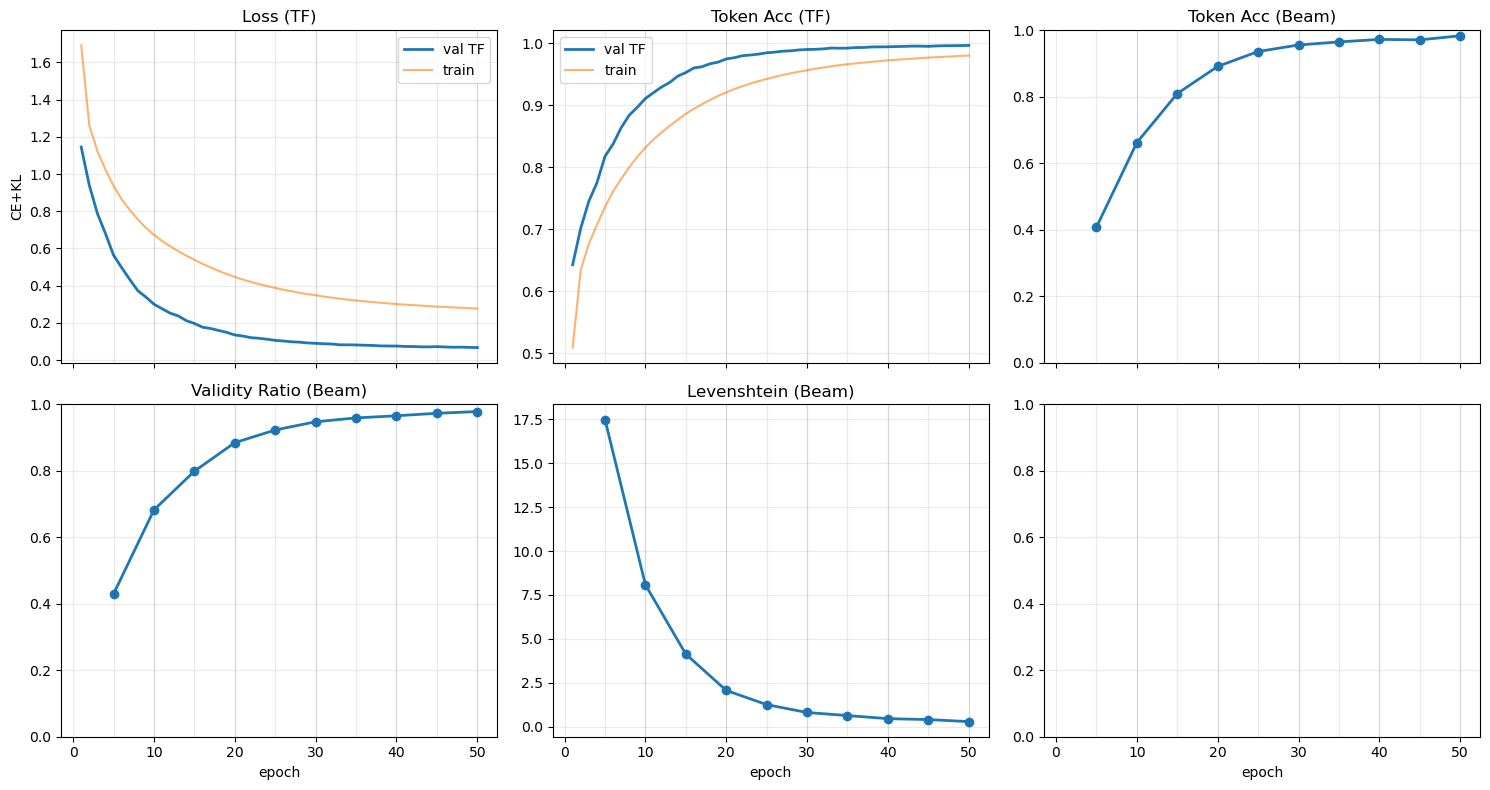

In [5]:
plt.plot_training_curves(history, beam_every=cfg["beam_every"], save_path=os.path.join(cfg["save_dir"], "training_curves.png"))